# Plot the Results

In [1]:
import pandas as pd

metrics_summary = pd.read_csv("metrics_with_labels_summary_90.csv")

In [2]:
color_map = {'DNN ESM2 35M': (0.00392156862745098,
  0.45098039215686275,
  0.6980392156862745),
 'DNN ESM2 150M': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 'DNN ESM2 8M': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 'DNN ProtBERT': (0.8352941176470589, 0.3686274509803922, 0.0),
 'DNN ESM2 3B': (0.8, 0.47058823529411764, 0.7372549019607844),
 'DNN ESM2 650M': (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 'DNN ESM1b': (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 'DeepEC CNN3': (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 'D-SPACE EC': (0.9254901960784314, 0.8823529411764706, 0.2),
 'Models + BLASTp': (0.00392156862745098,
  0.45098039215686275,
  0.6980392156862745),
 'Models ensemble': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
    'BLASTp': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),}

In [3]:
metrics_summary_80 = pd.read_csv("metrics_with_labels_summary_80.csv")
metrics_summary_70 = pd.read_csv("metrics_with_labels_summary_70.csv")
metrics_summary_60 = pd.read_csv("metrics_with_labels_summary_60.csv")
metrics_summary_50 = pd.read_csv("metrics_with_labels_summary_50.csv")
metrics_summary_40 = pd.read_csv("metrics_with_labels_summary_40.csv")

In [4]:
metrics_summary = pd.concat((metrics_summary, metrics_summary_80, metrics_summary_70, metrics_summary_60, metrics_summary_50, metrics_summary_40), ignore_index=True)
metrics_summary["tool_name"] = metrics_summary["tool_name"].replace({
    "deep_ec": "DeepEC CNN3",
    "dspace": "D-SPACE EC",
    "prot_bert": "DNN ProtBERT",
    "esm1b": "DNN ESM1b",
    "esm2_3B": "DNN ESM2 3B",
    "blast": "BLASTp",
    "models_ensemble": "Models ensemble",
    "models_blast": "Models + BLASTp"

})

In [14]:
import pandas as pd
from scipy.stats import wilcoxon
from itertools import combinations
from statsmodels.stats.multitest import multipletests

# Function to perform Wilcoxon test on F1 scores between two tools at a given identity threshold
def wilcoxon_test_by_identity(df, tool1, tool2, identity_level):
    subset = df[df["identity"] == identity_level]
    tool1_scores = subset[subset["tool_name"] == tool1]["f1_score"]
    tool2_scores = subset[subset["tool_name"] == tool2]["f1_score"]
    
    # Perform Wilcoxon rank-sum test if sample sizes match
    if len(tool1_scores) == len(tool2_scores):
        test_stat, p_value = wilcoxon(tool1_scores, tool2_scores)
        return {"identity_level": identity_level, "tool1": tool1, "tool2": tool2, "p_value": p_value}
    else:
        return {"identity_level": identity_level, "tool1": tool1, "tool2": tool2, "p_value": None, "note": "Mismatched sample sizes"}

# Function to perform Wilcoxon test for all combinations of tools at each identity level
def wilcoxon_test_all_combinations(df):
    results = []
    p_values = []
    identity_levels = df["identity"].unique()
    tool_names = df["tool_name"].unique()
    
    # Run tests and collect results
    for identity_level in identity_levels:
        for tool1, tool2 in combinations(tool_names, 2):
            result = wilcoxon_test_by_identity(df, tool1, tool2, identity_level)
            results.append(result)
            if result["p_value"] is not None:
                p_values.append(result["p_value"])
            else:
                p_values.append(1.0)  # Use a neutral p-value for cases with mismatched sample sizes to retain DataFrame structure

    # Apply FDR correction
    _, corrected_p_values, _, _ = multipletests(p_values, method='fdr_bh')

    # Insert corrected p-values back into results
    for i, result in enumerate(results):
        result["corrected_p_value"] = corrected_p_values[i]
    
    return pd.DataFrame(results)

# Run the tests with FDR correction on the results
results_df = wilcoxon_test_all_combinations(metrics_summary)
significant_results_df = results_df[results_df["corrected_p_value"] < 0.001]
significant_results_df.to_csv("statistical_significant_identity_thresholds.csv")


In [13]:
significant_results_df[significant_results_df["tool1"]=="DNN ESM1b"]

,identity_level,tool1,tool2,p_value,corrected_p_value
18,90.0,DNN ESM1b,DNN ESM2 3B,1.174753e-77,1.430134e-77
20,90.0,DNN ESM1b,Models + BLASTp,0.000000e+00,0.000000e+00
21,90.0,DNN ESM1b,Models ensemble,2.430868e-306,3.926787e-306
46,80.0,DNN ESM1b,DNN ESM2 3B,9.604324e-93,1.231700e-92
47,80.0,DNN ESM1b,DNN ProtBERT,2.025274e-12,2.087399e-12
48,80.0,DNN ESM1b,Models + BLASTp,0.000000e+00,0.000000e+00
49,80.0,DNN ESM1b,Models ensemble,9.816441e-300,1.555813e-299
74,70.0,DNN ESM1b,DNN ESM2 3B,1.294882e-99,1.699533e-99
75,70.0,DNN ESM1b,DNN ProtBERT,1.110658e-18,1.173525e-18
76,70.0,DNN ESM1b,Models + BLASTp,0.000000e+00,0.000000e+00


In [15]:
results[results["identity_level"] == 70]

,identity_level,tool1,tool2,p_value
56,70.0,BLASTp,DeepEC CNN3,0.000000e+00
57,70.0,BLASTp,D-SPACE EC,0.000000e+00
58,70.0,BLASTp,DNN ESM1b,3.953789e-211
59,70.0,BLASTp,DNN ESM2 3B,1.843292e-57
60,70.0,BLASTp,DNN ProtBERT,2.824509e-274
61,70.0,BLASTp,Models + BLASTp,3.405494e-37
62,70.0,BLASTp,Models ensemble,8.706740e-32
63,70.0,DeepEC CNN3,D-SPACE EC,1.720119e-53
64,70.0,DeepEC CNN3,DNN ESM1b,0.000000e+00
65,70.0,DeepEC CNN3,DNN ESM2 3B,0.000000e+00


In [56]:
grouped = metrics_summary.groupby(['identity', 'tool_name', 'fold']).agg(
        precision=('precision', 'mean'),
        recall=('recall', 'mean'),
        f1_score=('f1_score', 'mean'),
    )

grouped.reset_index()

,identity,tool_name,fold,precision,recall,f1_score
0,40.0,BLASTp,0,0.770043,0.769993,0.746193
1,40.0,BLASTp,1,0.769342,0.770531,0.744810
2,40.0,BLASTp,2,0.765787,0.755006,0.735234
3,40.0,BLASTp,3,0.772545,0.770126,0.749274
4,40.0,BLASTp,4,0.769167,0.763186,0.742733
...,...,...,...,...,...,...
235,90.0,Models ensemble,0,0.922035,0.871282,0.891743
236,90.0,Models ensemble,1,0.918973,0.870802,0.890164
237,90.0,Models ensemble,2,0.923729,0.870799,0.892030
238,90.0,Models ensemble,3,0.920397,0.868272,0.889152


In [57]:
grouped = metrics_summary.groupby(['identity', 'tool_name', 'fold']).agg(
        precision=('precision', 'mean'),
        recall=('recall', 'mean'),
        f1_score=('f1_score', 'mean'),
    ).reset_index()

grouped[grouped["fold"]==0]

,identity,tool_name,fold,precision,recall,f1_score
0,40.0,BLASTp,0,0.770043,0.769993,0.746193
5,40.0,D-SPACE EC,0,0.573714,0.362027,0.407463
10,40.0,DNN ESM1b,0,0.777749,0.680550,0.700932
15,40.0,DNN ESM2 3B,0,0.790114,0.699757,0.717773
20,40.0,DNN ProtBERT,0,0.778129,0.640253,0.674960
25,40.0,DeepEC CNN3,0,0.518292,0.371608,0.395205
30,40.0,Models + BLASTp,0,0.799823,0.739486,0.745845
35,40.0,Models ensemble,0,0.800932,0.680548,0.710707
40,50.0,BLASTp,0,0.828592,0.825599,0.814524
45,50.0,D-SPACE EC,0,0.709018,0.479113,0.539599


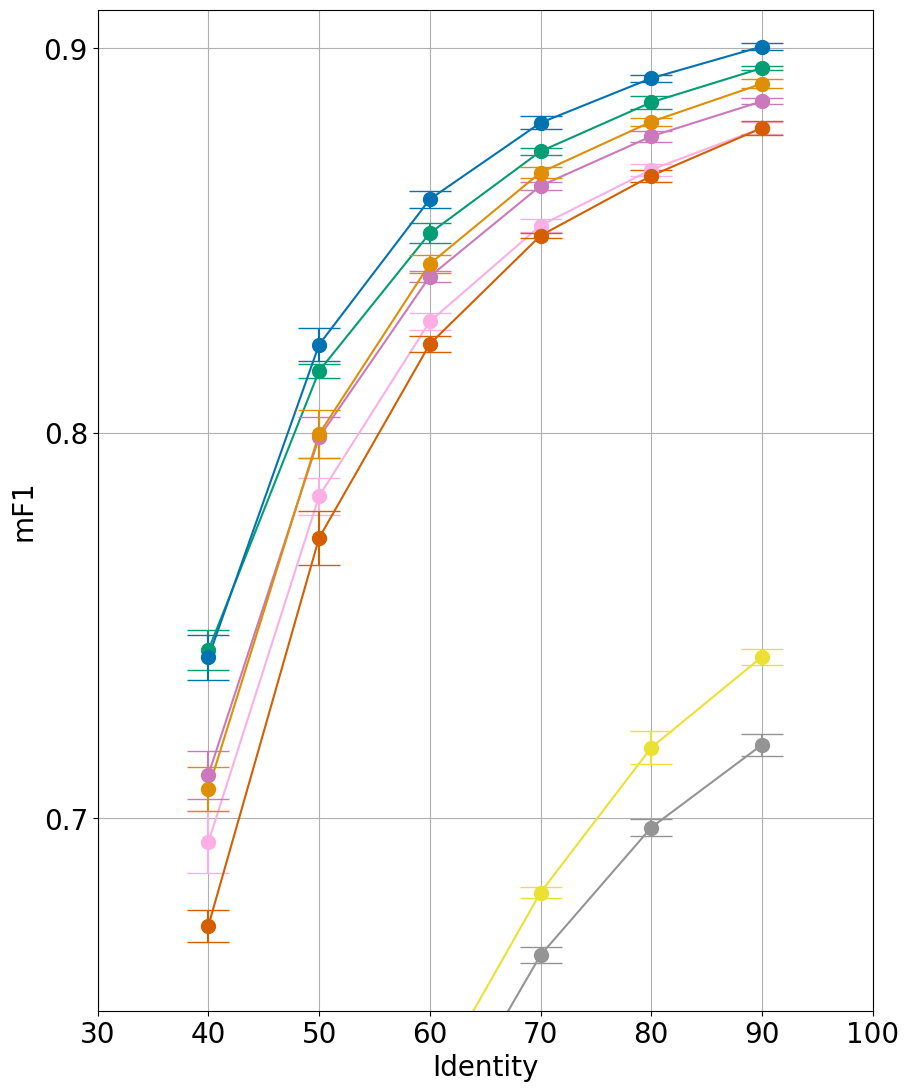

In [79]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

def plot_metrics(df, title):
    # Group the data by 'identity' and 'tool_name' (model), and calculate the mean and std for each metric
    grouped = df.groupby(['identity', 'tool_name', 'fold']).agg(
        precision=('precision', 'mean'),
        recall=('recall', 'mean'),
        f1_score=('f1_score', 'mean'),
    ).groupby(['identity', 'tool_name']).agg(mean_precision=('precision', 'mean'),
        std_precision=('precision', 'std'),
        mean_recall=('recall', 'mean'),
        std_recall=('recall', 'std'),
        mean_f1_score=('f1_score', 'mean'),
        std_f1_score=('f1_score', 'std')).reset_index()

    # List of metrics to plot
    metrics = ['f1_score']

    # Define a small offset to space out the points (in identity units)
    offsets = np.linspace(0, 0, len(grouped['tool_name'].unique()))  # Adjusts spacing

    # Plotting different points for each model with slight offset
    # Plotting different points for each model with slight offset
    for metric in metrics:
        plt.figure(figsize=(10, 13))
        
        # Loop over models and plot their points with slight offset on the x-axis
        for i, tool_name in enumerate(grouped['tool_name'].unique()):
            model_data = grouped[grouped['tool_name'] == tool_name]
            
            # Compute upper error bar, ensuring they don't exceed 1
            upper_error = np.minimum(model_data[f'std_{metric}'], 1 - model_data[f'mean_{metric}'])
            lower_error = model_data[f'std_{metric}']  # Lower error remains unchanged

            # Use the predefined color from the color_map
            color = color_map.get(tool_name, 'black')  # Default to black if tool_name not in color_map
       
            
            # Plot points with error bars and get the line properties
            errorbar_plot = plt.errorbar(
                model_data['identity'] + offsets[i],  # Slightly shift the x-axis values
                model_data[f'mean_{metric}'], 
                yerr=[lower_error, upper_error],  # Lower and upper error
                fmt='o', 
                capsize=15, 
                label=tool_name,
                color=color,
                markersize=10
            )
            
            # Get the color used by the current errorbar plot
            color = errorbar_plot[0].get_color()
            
            # Add line connecting the points for each model, using the same color
            plt.plot(
                model_data['identity'] + offsets[i],  # Slightly shift the x-axis values
                model_data[f'mean_{metric}'], 
                linestyle='-',  # Solid line to connect the points
                color=color  # Use the same color as the points
            )
        
        plt.title(title, pad = 25, size=22)
        plt.xlabel('Identity', size=20)
        plt.xticks(size=20)
        plt.ylabel(f'm{metric.capitalize()}'.replace("_score", ""), size=20)
        plt.yticks(ticks = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1], size=20)
        plt.ylim(0.65, 0.91)
        plt.xlim(30, 100)
        plt.grid(True)
        plt.legend(title='Model')
        
        # Increase the size of the error bars in the legend
        legend = plt.legend(
            bbox_to_anchor=(0.05, -0.3), 
            loc=2, 
            borderaxespad=0., 
            prop={'size': 25}, 
            ncol=2,
        )
        matplotlib.rcParams['savefig.transparent'] = True
        fig = legend.figure
        fig.canvas.draw()
        bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        fig.savefig("legend.png", dpi="figure", bbox_inches=bbox)
        legend.remove()
        plt.savefig(f"{title}.png", dpi=400, bbox_inches='tight')
        plt.show()


plot_metrics(metrics_summary, title="")

In [59]:
metrics_summary

,tool_name,fold,label,precision,recall,f1_score,identity
0,BLASTp,0,1,0.987838,0.982708,0.985266,90.0
1,BLASTp,0,2,0.988185,0.984445,0.986311,90.0
2,BLASTp,0,3,0.986987,0.976742,0.981837,90.0
3,BLASTp,0,4,0.967261,0.965660,0.966460,90.0
4,BLASTp,0,5,0.962382,0.961902,0.962142,90.0
...,...,...,...,...,...,...,...
654787,Models ensemble,4,7.6.2.11,1.000000,0.833333,0.909091,40.0
654788,Models ensemble,4,7.6.2.13,1.000000,0.412698,0.584270,40.0
654789,Models ensemble,4,7.6.2.2,0.520000,0.520000,0.520000,40.0
654790,Models ensemble,4,7.6.2.3,1.000000,1.000000,1.000000,40.0


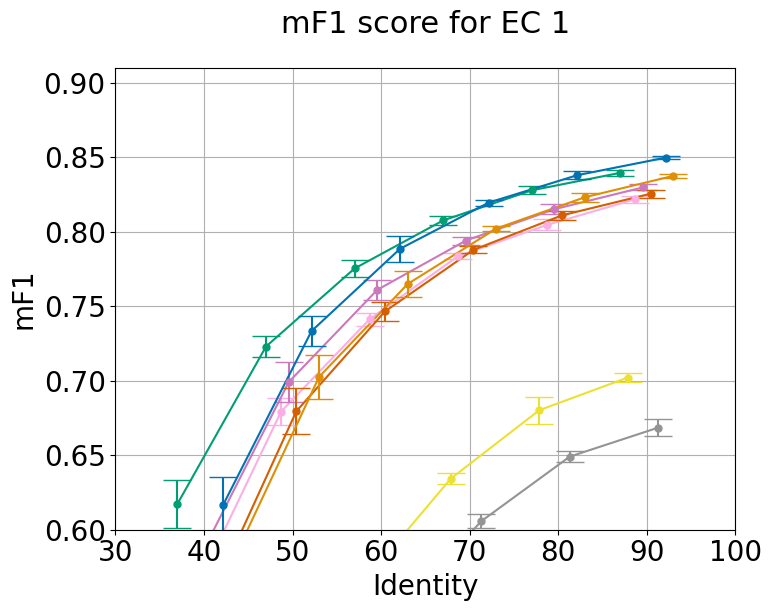

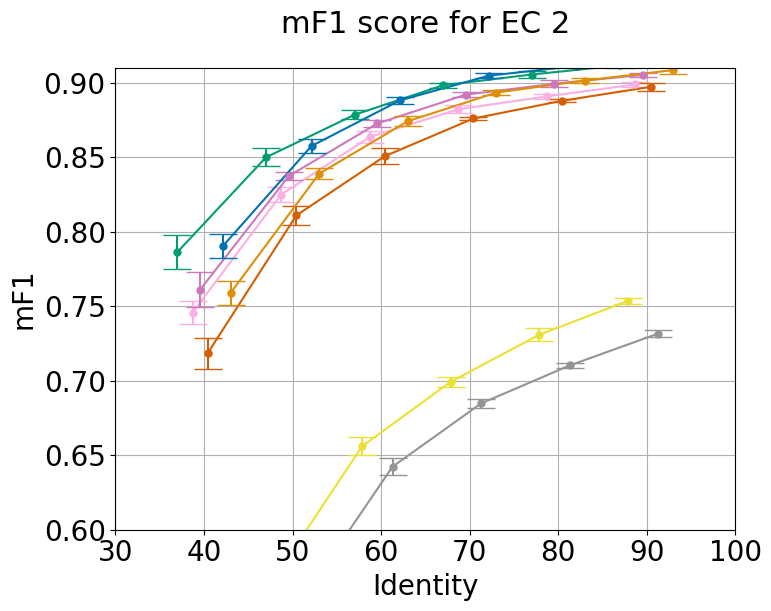

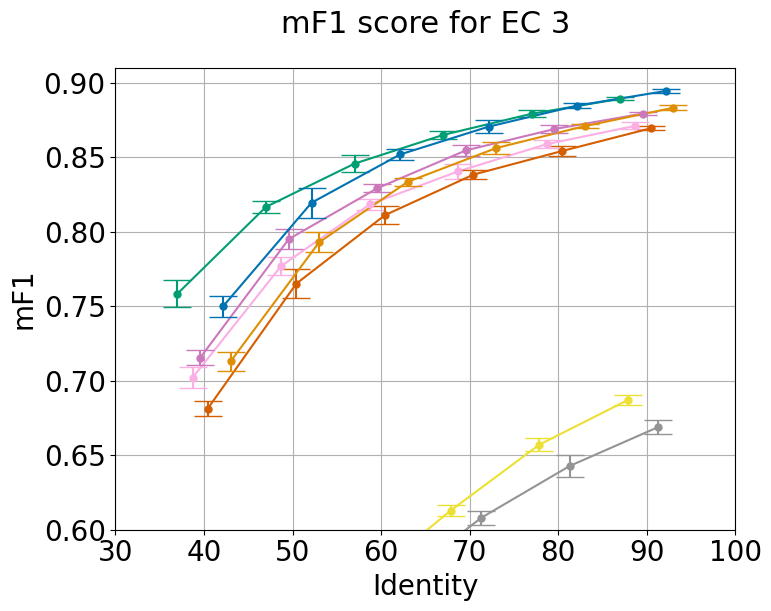

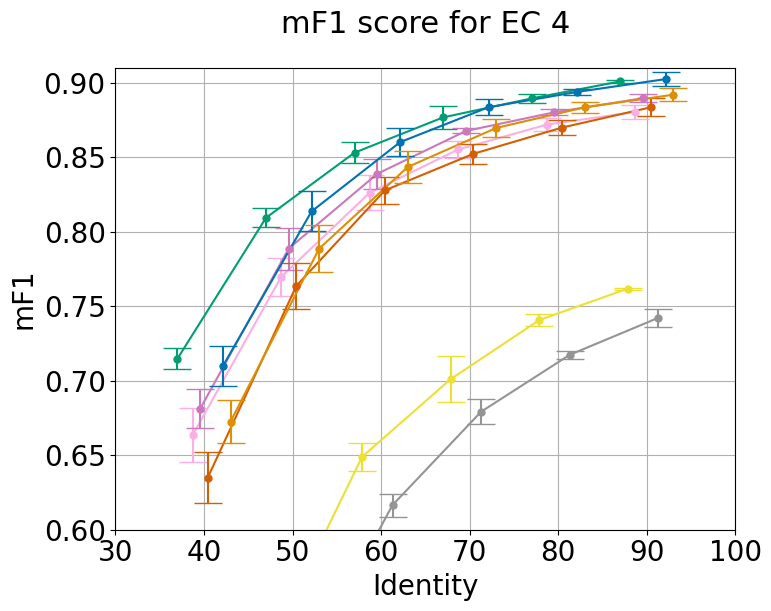

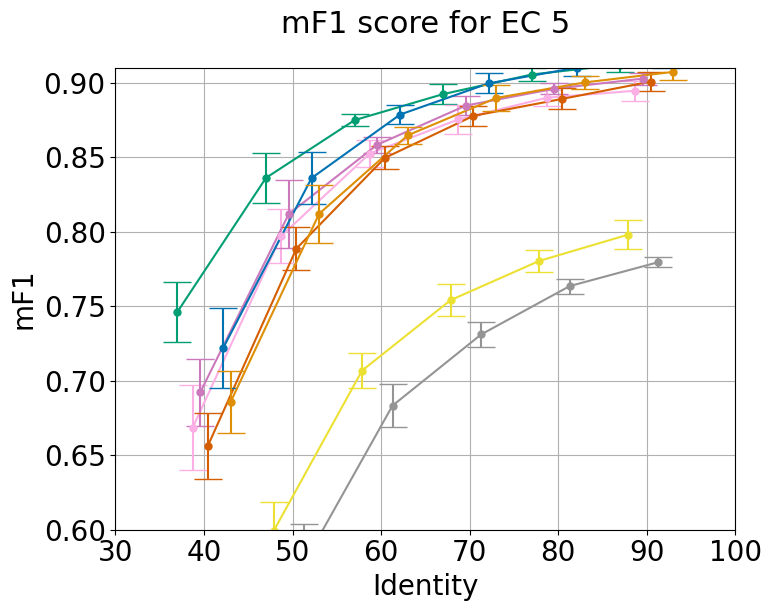

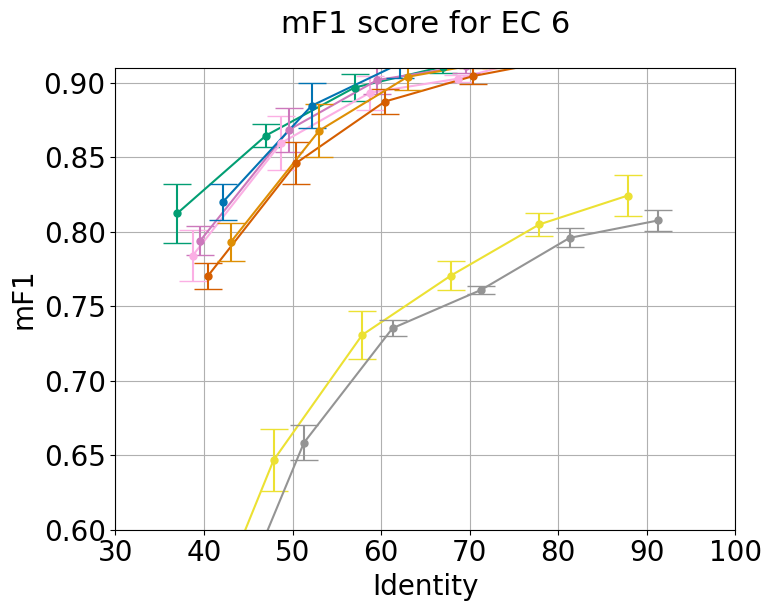

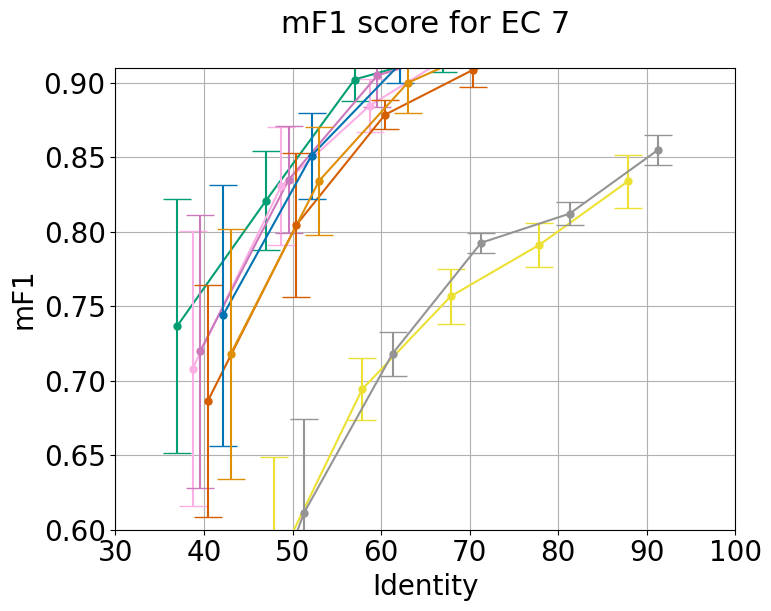

In [60]:


for ec in range(1, 8):
    pattern = rf"^{ec}.\d+.\d+.n*\d+$"

    filtered_df = metrics_summary[metrics_summary['label'].str.contains(pattern, regex=True)]
    plot_metrics(filtered_df, title=f"mF1 score for EC {ec}")